# Pytorch MNIST
---
by Pranpaveen Lay.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/layel2/pytorch-course/blob/main/5.pytorch-mnist.ipynb)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [3]:
data_train = torchvision.datasets.MNIST('./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
data_test = torchvision.datasets.MNIST('./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

In [4]:
data_train,data_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
data_train.data.shape

torch.Size([60000, 28, 28])

In [6]:
loader_train = torch.utils.data.DataLoader(data_train,batch_size=128)
loader_test = torch.utils.data.DataLoader(data_test,batch_size=128)

In [7]:
#examples = enumerate(loder_test)
for example_data, example_targets in loader_test :
    break

In [8]:
example_data.shape

torch.Size([128, 1, 28, 28])

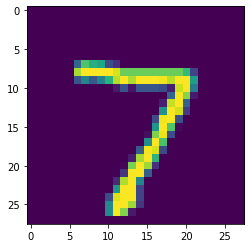

In [9]:
plt.imshow(example_data[0][0])

## Building model

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Sequential

In [11]:
model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(in_features=64 * 12 * 12, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=10),
            nn.LogSoftmax()
        )

### Model Class

In [12]:
class mnistmodel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2)
        self.dense1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
        self.dense2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.dropout(x, 0.25)
        x = nn.Flatten()(x)
        x = F.relu(self.dense1(x))
        x = F.dropout(x, 0.5)
        x = self.dense2(x)
        x = F.log_softmax(x)

        return x

In [13]:
model2 = mnistmodel_2()

In [14]:
from torchsummary import summary

In [15]:
summary(model.to(device),(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 12, 12]         102,464
              ReLU-4           [-1, 64, 12, 12]               0
           Dropout-5           [-1, 64, 12, 12]               0
           Flatten-6                 [-1, 9216]               0
            Linear-7                  [-1, 128]       1,179,776
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,285,194
Trainable params: 1,285,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

/home/lay/miniconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [16]:
summary(model2.to(device),(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
            Conv2d-2           [-1, 64, 12, 12]         102,464
            Linear-3                  [-1, 128]       1,179,776
            Linear-4                   [-1, 10]           1,290
Total params: 1,285,194
Trainable params: 1,285,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 4.90
Estimated Total Size (MB): 5.36
----------------------------------------------------------------


/tmp/ipykernel_16175/400680101.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


## Define function

In [17]:
def test(model,loader,verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(loader.dataset)
        test_acc = 100. * correct / len(loader.dataset)
        if verbose:
            print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({test_acc:.2f}%)\n')
        return test_loss, test_acc.item()

In [18]:
test(model,loader_test)

/home/lay/miniconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3078, Accuracy: 1268/10000 (12.68%)



(2.3078482078552245, 12.679999351501465)

In [19]:
train_losses = []
test_losses = []
n_epochs = 10

In [20]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [21]:
loss_fn = nn.NLLLoss()

In [22]:
log_interval = 100
def train(epoch,model=model,loader_train=loader_train, loss_fn = loss_fn):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(loader_train):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader_train.dataset),
                100. * batch_idx / len(loader_train), loss.item()))
            #train_losses.append(loss.item())
    #train_loss,train_acc = test(model,loader_train, verbose=False)
    train_loss /= len(loader_train.dataset)
    train_acc = 100. * correct / len(loader_train.dataset)
    test_loss,test_acc = test(model,loader_test, verbose=False)
    train_losses.append([train_loss,train_acc.item()])
    test_losses.append([test_loss,test_acc])
    print(f"epoch {epoch} : train_loss {train_loss:.6f}, train_acc {train_acc:.2f}, eval_loss {test_loss:.6f}, eval_acc {test_acc:.2f}")


In [23]:
for epoch in range(n_epochs):
    train(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305792
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.282013
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.132020
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.148526
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.128106
epoch 0 : train_loss 0.001950, train_acc 92.32, eval_loss 0.052899, eval_acc 98.20
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.095884
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.059671
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.127917
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.058926
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.160071
epoch 1 : train_loss 0.000708, train_acc 97.34, eval_loss 0.040692, eval_acc 98.63
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.058239
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.060736
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.076005
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.058946
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.125777
epoch 2 : train_loss 0.000498, train_acc 98.15, eval_loss 0.036201, eval_acc 98.78
Train Epoch: 3 [

Text(0.5, 1.0, 'Loss')

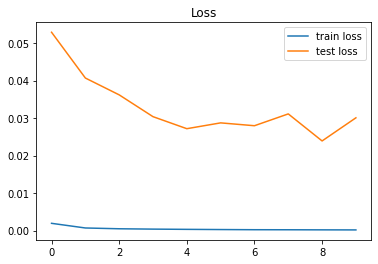

In [24]:
plt.plot(np.array(train_losses)[:,0])
plt.plot(np.array(test_losses)[:,0])
plt.legend(['train loss','test loss'])
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

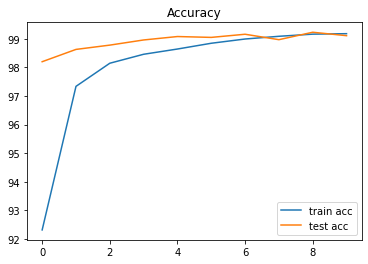

In [25]:
plt.plot(np.array(train_losses)[:,1])
plt.plot(np.array(test_losses)[:,1])
plt.legend(['train acc','test acc'])
plt.title('Accuracy')

## save model

In [26]:
!mkdir saved_model

mkdir: cannot create directory ‘saved_model’: File exists


In [27]:
torch.save(model, 'saved_model/minst_model.pth')

In [28]:
torch.save(model.state_dict(), 'saved_model/mnist_model_weights.pth')

In [29]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[[[ 0.0813, -0.0930, -0.1211, -0.0530, -0.0123],
                        [ 0.1390, -0.0608,  0.0307, -0.2377, -0.1902],
                        [-0.0137,  0.2800, -0.0341,  0.1889,  0.0703],
                        [ 0.0262,  0.0589,  0.1862,  0.2660,  0.2129],
                        [-0.1143, -0.1497, -0.1202, -0.1200, -0.1000]]],
              
              
                      [[[-0.1644, -0.1992, -0.0822,  0.0543,  0.1311],
                        [-0.1919, -0.0864,  0.0383,  0.1557,  0.0559],
                        [-0.2030, -0.1885, -0.1732,  0.1742,  0.1862],
                        [ 0.1086, -0.0690,  0.0923, -0.0004,  0.0747],
                        [ 0.1736, -0.0779, -0.2006,  0.1309,  0.1396]]],
              
              
                      [[[-0.0792, -0.1277,  0.0135, -0.0980, -0.3119],
                        [-0.1062, -0.1178, -0.1044,  0.1077, -0.2018],
                        [-0.0875, -0.0660,  0.0616,  0.117

In [30]:
torch.save(model2, 'saved_model/minst_model_class.pth')
torch.save(model2.state_dict(), 'saved_model/mnist_model_class_weights.pth')